<h1><center>Machine Learning applied to Stock Market</center></h1>

Based on the video *Stock Price Prediction Using Python & Machine Learning* by  **Computer Science** https://youtu.be/QIUxPv5PJOY

### This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the closing stock price of a corporation (Apple Inc) using the past 60 day stock price.

Let's begin by importing the necessary libraries

In [2]:
import math
import pandas_datareader as web
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models            import Sequential
from keras.layers            import Dense, LSTM
from pandas.plotting         import register_matplotlib_converters

pd.options.mode.chained_assignment = None
register_matplotlib_converters()
plt.style.use('fivethirtyeight')

Now that we have all the tools needed, let's import the data

In [3]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

Before doing anything else we can plot the data to have a better idea of what we have. We want to plot the Close Price of the actions for every day in our dataset

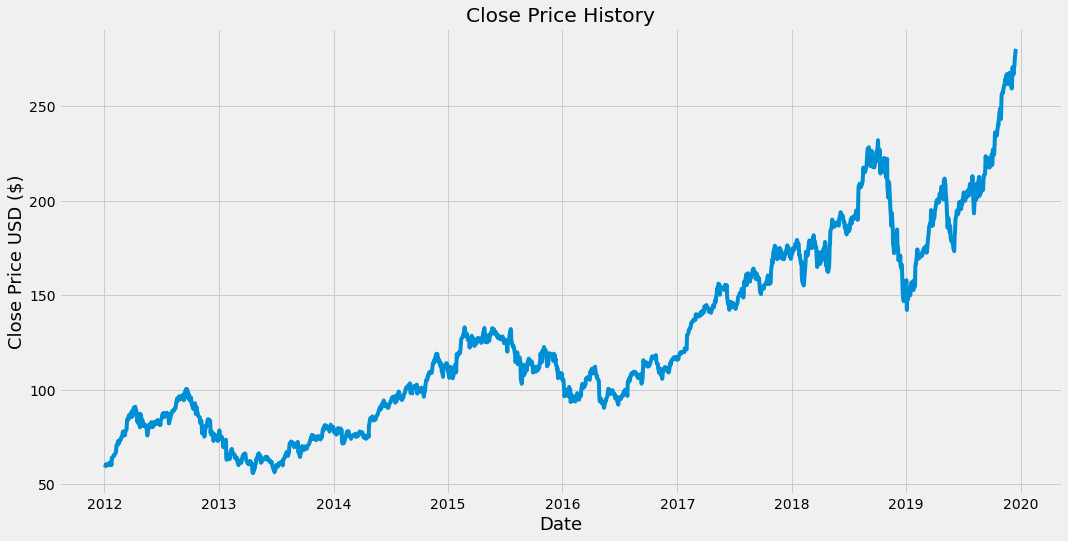

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

Of every possible features that we have we are only interestid in the close value, since we use the prior close values to predict the next ones

In [5]:
#Create a new data frame with only the 'Close column'
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values

As always it is useful to scale our data in a new set of data that has his mean at $\mu=0$ and a deviation of $\sigma=1$. We use the StandardScaler Method for this task.

It is also possible to Scale the data by normalization, as the author from the original source did. The results are pretty similar. I checked the influence of the scaler in the RMSE and it did not change by much

In [6]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01316509],
       [0.01457064],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

Now we create our target data. First we need to stablish how many numbers prior our prediction we are going to take into account. We define this in the $N_{prior}$ variable

In [7]:
Nprior = 60

Now we need to create, for every $N_{prior}$ numbers, a label. This label will be the next number after counting $N_{prior}$, no matter where we start. For that purpose, we create a loop. After that we convert the data and target to numpy array

In [8]:
x = []
y = []
for i in range(Nprior,len(scaled_data)):
    x.append(scaled_data[i-Nprior:i, 0])
    y.append(scaled_data[i, 0])

x,y = np.array(x),np.array(y)

After this we can split our data. Note that is important to not shuffle the data since in this case the order of our data is important to predict the label. You can try to change False to True to see what happens

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
                                   x, y, test_size=0.2, random_state=None, shuffle=False)

We need to reshape the data in order to sklearn to understand it. The shape this data must have is an (3x1) array containing the following information in every place:

1. The Number of Samples
2. The Number of Timesteps ($N_{prior}$)
3. Number of Features (1, the Close Price)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test  = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1 ))

Now, to build our NN: We add a couple of layers of the Long Short Term Memory layer with 50 nodes followed by a Dense Layer with 25 Nodes and an Output Layer with only one node, of course, which is going to be the final result

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

We compile this model using the ADAM optimizer, since it generally outperforms other optimizers and using the MSE loss function

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

Now we train our model without using batches and only with one epoch, but this is tunneable

In [13]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1554/1554 [==============================] - 64s 41ms/step - loss: 6.9960e-04


Now with our model trained we can predict the target of our test data

In [14]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

We can calculate the RMSE as well

In [15]:
#Get the root mean squared error (RMSE)
rmse= np.sqrt(np.mean((predictions-y_test)**2))
print('RMSE =',rmse)

RMSE = 200.7109527945318


And Finally we can plot the data

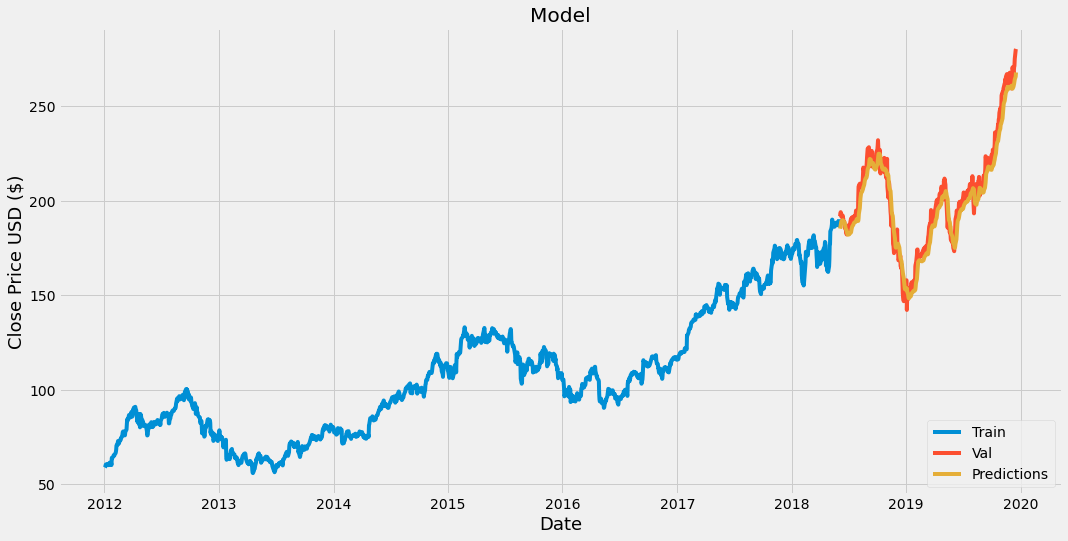

In [16]:
training_data_len=len(data)-len(predictions)
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions']= predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show()

We see our predictions do not differ by much from the test data, so we can proceed and become extremely wealthy thanks to ML! We can also predict a specific day by applying the following structure

In [17]:
#Get the quote
apple_quote= web.DataReader('AAPL',data_source='yahoo',start='2012-01-01', end='2019-12-17')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get the last 60 day closing prince values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append the past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[270.14752]]


And, comparing with the actual result:

In [18]:
### Get the quote
apple_quote2= web.DataReader('AAPL',data_source='yahoo',start='2019-12-18', end='2019-12-18')
print(apple_quote2['Close'])

Date
2019-12-18    279.73999
Name: Close, dtype: float64


We obtain a difference of a

In [19]:
porc=100*abs(apple_quote2['Close'].values-pred_price)/apple_quote2['Close'].values
print('Difference of a',porc[0][0],'% between the next predicted value and the real one')

Difference of a 3.4290657741432953 % between the next predicted value and the real one
